# Using shapefiles to crop raster data

Contributors: Susanne Brockmann

## Imports

In [1]:
import pandas as pd
import csv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from descartes import PolygonPatch

from matplotlib import pyplot as plt
import geojson
from shapely.geometry import Point, mapping, shape, Polygon
from fiona import collection
import fiona
import geopandas as gpd
import geoplot

## Setting up the data access

In [2]:
#H:\Omdena-food\GPSDD-Food-Security-Senegal\data\data\Landsat_8_Region
#H:\Omdena-food\GPSDD-Food-Security-Senegal\data\Regions
#raster_data_folder = Path.cwd().parent.parent.joinpath('data', 'data', 'Landsat_8_Region')
raster_data_folder = Path.cwd().parent.parent.joinpath('data', 'Regions', 'MOD09A1_TerraSurfaceReflectance_Senegal_regions')
print(raster_data_folder)
#input_filename = 'matam_region_2015.tif'
#input_filename = 'senegal_reflectance_senegal-dakar_2015-01-01_2016-01-01.tif'
input_filename = 'senegal_reflectance_senegal-matam_2015-01-01_2016-01-01.tif'
input_raster_file= Path(raster_data_folder).joinpath(input_filename)
print(input_raster_file)

H:\Omdena-food\GPSDD-Food-Security-Senegal\data\Regions\MOD09A1_TerraSurfaceReflectance_Senegal_regions
H:\Omdena-food\GPSDD-Food-Security-Senegal\data\Regions\MOD09A1_TerraSurfaceReflectance_Senegal_regions\senegal_reflectance_senegal-matam_2015-01-01_2016-01-01.tif


In [4]:
try:
    open(input_raster_file)
except:
    print(f"The file '{input_raster_file}' is not available at the specified location. Please download it.")
# TODO: Create automatic download from S3 and extraction into the corresponding folder 

In [5]:
data_folder = Path.cwd().parent.parent.joinpath('data', )
#print(data_folder)
file_name = "yields_IPAR - rice_CSC.csv"
rice_irr_file_path = Path(data_folder).joinpath("external", "IPAR", file_name)
print(rice_irr_file_path)

H:\Omdena-food\GPSDD-Food-Security-Senegal\data\external\IPAR\yields_IPAR - rice_CSC.csv


In [6]:
rice_irr_yield = pd.read_csv(rice_irr_file_path)
rice_irr_yield

,KEY,ID_menage,riz_irrig_csc2,riz_irrig_hiv2,crops_cult1 irrigated rice,season_cult1,Area planted (ha) irrigated rice,Quantity produced (Kg) irrigated rice,Yield (T/ha),Department,Counties,Village,gpslat,gpslon
0,uuid:05583819-bbbb-48cf-831f-90837030102a,5.580000e+38,1,0,CSC Irrigated Rice,3,0.50,700.0,1.400000,MATAM,NABADJI-CIVOL,SEDDO ABBAS,15.775458,-13.468248
1,uuid:826eea2b-e840-428c-bfc0-3322b56a4354,8.270000e+39,1,1,CSC Irrigated Rice,2,5.00,30750.0,6.150000,DAGANA,DIAMA,MBOUNDOUME BARRAGE,16.399498,-16.075737
2,uuid:abcf1d41-bab2-4340-a7c8-03e610962e46,1.240000e+39,1,0,CSC Irrigated Rice,2,0.40,2820.0,7.050000,DAGANA,BOKHOL,BOKHOL,16.522778,-15.399270
3,uuid:ab37f2a6-51f4-41c2-9ff4-9d30d66c358e,1.240000e+39,1,0,CSC Irrigated Rice,2,1.00,4000.0,4.000000,DAGANA,RONKH,H3 KEUR L ISLAM,16.341932,-16.004917
4,uuid:3513b03f-dde4-4f87-88a3-44e34125b968,3.510000e+39,1,0,CSC Irrigated Rice,2,1.00,5760.0,5.760000,DAGANA,RONKH,H3 KEUR L ISLAM,16.342237,-16.004182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,uuid:e784fac7-e07a-4f29-9f40-0b9b7d1b074e,5.780000e+39,1,0,CSC Irrigated Rice,1,1.00,1400.0,1.400000,MATAM,BOKIDIAWE,BOKIDIAWE SARAKHOLE,NaN,NaN
155,uuid:b2db5d38-9240-48c1-8035-259d442669c0,2.240000e+39,1,0,CSC Irrigated Rice,2,3.46,14940.0,4.317919,DAGANA,RONKH,KHEUNE,16.522475,-16.108760
156,uuid:0be59f89-7e8c-4f90-86bc-beaf7d86f21c,2.560000e+38,1,0,CSC Irrigated Rice,2,0.57,3500.0,6.140351,PODOR,NDIAYENE PENDAO,NDIAYENNE PENDAO,16.503432,-15.047150
157,uuid:4015788a-b9c1-4a9d-942b-c5797bc003e1,4.020000e+39,1,0,CSC Irrigated Rice,2,3.00,7040.0,2.346667,DAGANA,DIAMA,MBOUNDOUME BARRAGE,16.398233,-16.076235


In [7]:
# create a geopandas dataframe and set the crs
rice_irr_yield_gpd = gpd.GeoDataFrame(rice_irr_yield, geometry=gpd.points_from_xy(rice_irr_yield.gpslon, rice_irr_yield.gpslat))
rice_irr_yield_gpd.crs ='EPSG:4326'
rice_irr_yield_gpd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
rice_irr_yield_gpd.head()

,KEY,ID_menage,riz_irrig_csc2,riz_irrig_hiv2,crops_cult1 irrigated rice,season_cult1,Area planted (ha) irrigated rice,Quantity produced (Kg) irrigated rice,Yield (T/ha),Department,Counties,Village,gpslat,gpslon,geometry
0,uuid:05583819-bbbb-48cf-831f-90837030102a,5.580000e+38,1,0,CSC Irrigated Rice,3,0.5,700.0,1.40,MATAM,NABADJI-CIVOL,SEDDO ABBAS,15.775458,-13.468248,POINT (-13.46825 15.77546)
1,uuid:826eea2b-e840-428c-bfc0-3322b56a4354,8.270000e+39,1,1,CSC Irrigated Rice,2,5.0,30750.0,6.15,DAGANA,DIAMA,MBOUNDOUME BARRAGE,16.399498,-16.075737,POINT (-16.07574 16.39950)
2,uuid:abcf1d41-bab2-4340-a7c8-03e610962e46,1.240000e+39,1,0,CSC Irrigated Rice,2,0.4,2820.0,7.05,DAGANA,BOKHOL,BOKHOL,16.522778,-15.399270,POINT (-15.39927 16.52278)
3,uuid:ab37f2a6-51f4-41c2-9ff4-9d30d66c358e,1.240000e+39,1,0,CSC Irrigated Rice,2,1.0,4000.0,4.00,DAGANA,RONKH,H3 KEUR L ISLAM,16.341932,-16.004917,POINT (-16.00492 16.34193)
4,uuid:3513b03f-dde4-4f87-88a3-44e34125b968,3.510000e+39,1,0,CSC Irrigated Rice,2,1.0,5760.0,5.76,DAGANA,RONKH,H3 KEUR L ISLAM,16.342237,-16.004182,POINT (-16.00418 16.34224)


In [17]:
rice_irr_yield_gpd.geometry

0      POINT (-13.46825 15.77546)
1      POINT (-16.07574 16.39950)
2      POINT (-15.39927 16.52278)
3      POINT (-16.00492 16.34193)
4      POINT (-16.00418 16.34224)
                  ...            
154               POINT (nan nan)
155    POINT (-16.10876 16.52248)
156    POINT (-15.04715 16.50343)
157    POINT (-16.07624 16.39823)
158    POINT (-16.10863 16.52243)
Name: geometry, Length: 159, dtype: geometry

In [9]:
rice_irr_yield_gpd = rice_irr_yield_gpd.dropna()

In [10]:
length = 1000 # width and height of square in meters

rice_irr_yield_gpd['lat_long_m'] = rice_irr_yield_gpd['geometry'].to_crs('epsg:3395')
# set the shapefile column to geometry for easy access
# the geometry attribute determines which column contains the "spatial" data
rice_irr_yield_gpd.set_geometry('lat_long_m')
# creates a tuple of bbox coordinates arround a buffered point 
#rice_irr_yield_gpd['bbox'] = rice_irr_yield_gpd.apply(lambda x: x.lat_long_m.buffer(length/2).bounds, axis=1) 
bbox = rice_irr_yield_gpd.apply(lambda x: Polygon.from_bounds(*x.lat_long_m.buffer(length/2).bounds), axis=1) 

bbox_gdf = gpd.GeoSeries(bbox, crs='epsg:3395')
bbox_gdf_4326 = bbox_gdf.to_crs('epsg:4326')
bbox_gdf_4326

#rice_irr_yield_gpd.set_geometry('bbox')
#rice_irr_yield_gpd['bbox_4326'] = rice_irr_yield_gpd['bbox'].to_crs('epsg:4326')

#rice_irr_yield_gpd.set_geometry('bbox_coords')
#rice_irr_yield_gpd['bbox_4326'] = rice_irr_yield_gpd['bbox_coords'].to_crs('epsg:4326')

#rice_irr_yield_gpd.info()
#rice_irr_yield_gpd.head()

0      POLYGON ((-13.47274 15.77111, -13.47274 15.779...
1      POLYGON ((-16.08023 16.39516, -16.08023 16.403...
2      POLYGON ((-15.40376 16.51845, -15.40376 16.527...
3      POLYGON ((-16.00941 16.33759, -16.00941 16.346...
4      POLYGON ((-16.00867 16.33790, -16.00867 16.346...
                             ...                        
153    POLYGON ((-13.32818 15.60290, -13.32818 15.611...
155    POLYGON ((-16.11325 16.51814, -16.11325 16.526...
156    POLYGON ((-15.05164 16.49910, -15.05164 16.507...
157    POLYGON ((-16.08073 16.39390, -16.08073 16.402...
158    POLYGON ((-16.11312 16.51810, -16.11312 16.526...
Length: 157, dtype: geometry

In [34]:
shape = [bbox_gdf_4326[0]]
shape[0]#.bounds

[0    POLYGON ((-13.47274 15.77111, -13.47274 15.779...
 1    POLYGON ((-16.08023 16.39516, -16.08023 16.403...
 2    POLYGON ((-15.40376 16.51845, -15.40376 16.527...
 dtype: geometry]

In [12]:
# read geometries, and mask out regions of a raster that are outside the polygons defined in the shapefile
with rasterio.open(input_raster_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shape, crop=True)
    out_meta = src.meta
# save the resulting raster
out_meta.update({"driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
"transform": out_transform})

In [13]:
out_meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 8,
 'height': 7,
 'count': 322,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0013474729261792823, 0.0, -13.473381788866645,
        0.0, -0.0013474729261792823, 15.780255438485575)}

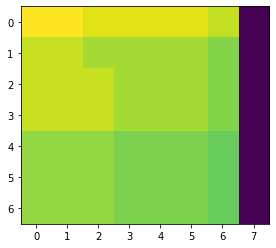

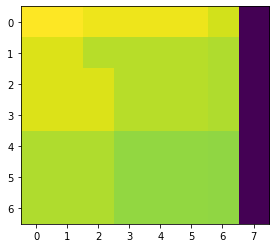

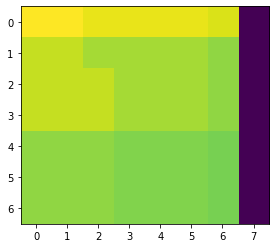

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

In [14]:
show(out_image[0]), show(out_image[1]),  show(out_image[2])

In [ ]:

with rasterio.open("masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [15]:
raster_data = rasterio.open(input_raster_file)

In [16]:
raster_data.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 1678,
 'height': 1295,
 'count': 322,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0013474729261792823, 0.0, -14.85049911942187,
        0.0, -0.0013474729261792823, 16.150810493184878)}

In [17]:
data= raster_data.read()

In [148]:
#print(raster_data.crs.linear_units)

In [18]:
raster_data.bounds

BoundingBox(left=-14.85049911942187, bottom=14.405833053782708, right=-12.589439549293035, top=16.150810493184878)

<AxesSubplot:>

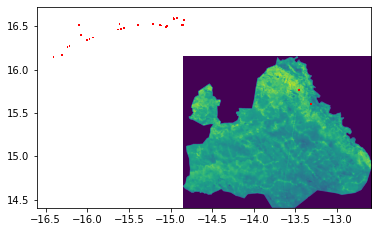

In [35]:
f, ax = plt.subplots()
#plt.imshow(data)
show(raster_data, ax= ax, with_bounds=True, transform=raster_data.transform)
bbox_gdf_4326.plot(ax=ax, markersize=1, edgecolor = 'red')

Notes:
The above code tries to create a bounding box in meters. Due to the low resolution of the images we get irregularly shaped masks. To avoid this we should create the bounding box based on the pixels of the image not of meters on ground.
https://gis.stackexchange.com/questions/299787/finding-pixel-location-in-raster-using-coordinates

In [27]:
WIDTH = 85
HEIGHT = 83
CENTER_DISTANCE = 70  # Hyperparameter to tune?

In [28]:
i = 0
lat = rice_irr_yield_gpd.loc[i, 'gpslat']
lon = rice_irr_yield_gpd.loc[i, 'gpslon']
print(lat, lon)

15.77545833 -13.46824833


In [25]:
# Get pixel coordinates from map coordinates
py, px = raster_data.index(lon, lat)
print('Pixel Y, X coords: {}, {}'.format(py, px))

Pixel Y, X coords: 278, 1025


In [26]:
# create a window for cropping the data or partially reading the data
window = rasterio.windows.Window(px - WIDTH//2, py - HEIGHT//2, WIDTH, HEIGHT)
print(window)

Window(col_off=983, row_off=237, width=85, height=83)


In [31]:
# clip is a nbands * N * N numpy array
clip = raster_data.read(window=window)

# You can then write out a new file
clip_meta = raster_data.meta
clip_meta['width'], clip_meta['height'] = WIDTH, HEIGHT
clip_meta['transform'] = rasterio.windows.transform(window, raster_data.transform)

In [ ]:
# out_meta.update({"driver": "GTiff",
#     "height": out_image.shape[1],
#     "width": out_image.shape[2],
# "transform": out_transform})

In [ ]:
# with rio.open(outfile.format(i), 'w', **clip_meta) as dst:
#     dst.write(clip)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

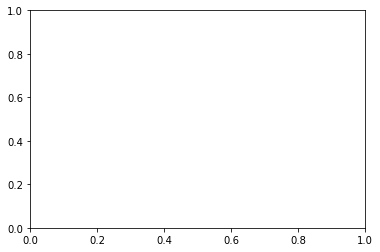

In [37]:
f, ax1 = plt.subplots()
#plt.imshow(data)
show(clip, ax= ax1,  with_bounds=True, transform=clip.transform)

In [39]:
clip.shape

(322, 83, 85)